In [10]:
using DifferentialEquations, Plots, DataFrames, BenchmarkTools

In [11]:
function odemodel!(dydt, initial, params, t)
    b, dm, kb, ku, f, thetar, k_cm, s0, gmax, cl, thetax, Kt, M, we, Km, vm, nx, Kq, Kp, vt, wr, wq, wp, hq, nr, ns = params
    r, et, em, q, si, a, p, mr, mt, mm, mq, mp, cr, ct, cm, cq, cp = initial

    dr, det, dem, dq, dsi, da, dp, dmr, dmt, dmm, dmq, dmp, dcr, dct, dcm, dcq, dcp = zeros(length(dydt))

    Kgamma = gmax/Kp
    gamma = gmax*a/(Kgamma+a)
    ttrate = (cq+cr+cp+ct+cm)*gamma
    lam = ttrate/M

    # dilution
    # 1st set
    function dilution(x) lam*x end
    dr = dr - dilution(r)
    det = det - dilution(et)
    dem = dem - dilution(em)
    dq = dq - dilution(q)
    dp = dp - dilution(p)
    dsi = dsi - dilution(si)
    da = da - dilution(a)
    # 2nd set
    dmr = dmr - dilution(mr)
    dmt = dmt - dilution(mt)
    dmm = dmm - dilution(mm)
    dmq = dmq - dilution(mq)
    dmp = dmp - dilution(mp)
    # 3rd set 
    dcr = dcr - dilution(cr)
    dct = dct - dilution(ct)
    dcm = dcm - dilution(cm)
    dcq = dcq - dilution(cq)
    dcp = dcp - dilution(cp)

    # transcription 
    function transcription(wx, theta) wx*a/(theta+a) end
    dmr = dmr + transcription(wr, thetar)
    dmt = dmt + transcription(we, thetax)
    dmm = dmm + transcription(we, thetax)
    dmp = dmp + transcription(we, thetax)
    # q-compartment inhibition 
    qin = 1+(q/Kq)^hq
    dmq = dmq + transcription(wq, thetax)/qin

    # degradation
    function degradation(mx) dm*mx end
    dmr = dmr - degradation(mr)
    dmt = dmt - degradation(mt)
    dmm = dmm - degradation(mm)
    dmq = dmq - degradation(mq)
    dmp = dmp - degradation(mp)

    # binding 
    function bind(mx) kb*r*mx end 
    function unbind(cx) ku*cx end
    dr = dr - bind(mr) + unbind(cr) - bind(mt) + unbind(ct) - bind(mm) + unbind(cm) - bind(mq) + unbind(cq) - bind(mp) + unbind(cp)
    dmr = dmr - bind(mr) + unbind(cr)
    dmt = dmt - bind(mt) + unbind(ct)
    dmm = dmm - bind(mm) + unbind(cm)
    dmq = dmq - bind(mq) + unbind(cq)
    dmp = dmp - bind(mp) + unbind(cp)
    dcr = dcr + bind(mr) - unbind(cr)
    dct = dct + bind(mt) - unbind(ct)
    dcm = dcm + bind(mm) - unbind(cm)
    dcq = dcq + bind(mq) - unbind(cq)
    dcp = dcp + bind(mp) - unbind(cp)

    # translation
    function translation(cx, nx) cx*gamma/nx end
    Kgamma = gmax/Kp
    gamma = gmax*a/(Kgamma+a)
    dcr = dcr - translation(cr, nr)
    dct = dct - translation(ct, nx)
    dcm = dcm - translation(cm, nx)
    dcq = dcq - translation(cq, nx)
    dcp = dcp - translation(cp, nx)
    dmr = dmr + translation(cr, nr) 
    dmt = dmt + translation(ct, nx)
    dmm = dmm + translation(cm, nx)
    dmq = dmq + translation(cq, nx)
    dmp = dmp + translation(cp, nx)
    dr = dr + translation(cr, nr) + translation(cr, nr) + translation(ct, nx) + translation(cm, nx) + translation(cq, nx) + translation(cp, nx)
    det = det + translation(ct, nx)
    dem = dem + translation(cm, nx)
    dq = dq + translation(cq, nx)
    da = da - gamma*(cq + cr + ct + cm)
    dp = dp + translation(cp, nx)

    # nutrient import 
    vimp = et*vt*s0/(Kt+s0)
    # metabolism
    nucat = em*vm*si/(Km+si)

    dsi = dsi + vimp - nucat
    da = da + nucat * ns 

    dydt[1] = dr
    dydt[2] = det
    dydt[3] = dem
    dydt[4] = dq
    dydt[5] = dsi
    dydt[6] = da
    dydt[7] = dp
    dydt[8] = dmr
    dydt[9] = dmt
    dydt[10] = dmm
    dydt[11] = dmq
    dydt[12] = dmp
    dydt[13] = dcr
    dydt[14] = dct
    dydt[15] = dcm
    dydt[16] = dcq
    dydt[17] = dcp


end

function odemodelfull!(dydt, initial, params, t)
    b, dm, kb, ku, f, thetar, k_cm, s0, gmax, cl, thetax, Kt, M, we, Km, vm, nx, Kq, Kp, vt, wr, wq, wp, hq, nr, ns = params
    cr, em, cp, cq, ct, et, cm, mt, mm, q, p, si, mq, mp, mr, r, a, zmr, zmp, zmq, zmt, zmm = initial

    dcr, dem, dcp, dcq, dct, det, dcm, dmt, dmm, dq, dp, dsi, dmq, dmp, dmr, dr, da, dzmr, dzmp, dzmq, dzmt, dzmm = zeros(length(dydt))

    Kgamma = gmax/Kp
    gamma = gmax*a/(Kgamma+a)
    ttrate = (cq+cr+cp+ct+cm)*gamma
    lam = ttrate/M
    vimp = (et*vt*s0)/(Kt+s0)
    nucat = (em*vm*si)/(Km+si)

    dydt[1] =  +r*mr*kb - cr*ku - cr*lam - cr*gamma/nr - f*cr + b*zmr
    dydt[2] = - lam*em + cm*gamma/nx
    dydt[3] =   +r*mp*kb - cp*ku - cp*lam - cp*gamma/nx - f*cp + b*zmp
    dydt[4] =  +r*mq*kb - cq*ku - cq*lam - cq*gamma/nx - f*cq + b*zmq
    dydt[5] =  +r*mt*kb - ct*ku - ct*lam - ct*gamma/nx - f*ct + b*zmt
    dydt[6] =  - lam*et + ct*gamma/nx
    dydt[7] =   +r*mm*kb - cm*ku - cm*lam - cm*gamma/nx - f*cm + b*zmm
    dydt[8] =   +we*a/(thetax+a) - mt*lam - mt*dm - r*mt*kb + ct*ku + ct*gamma/nx
    dydt[9] =   +we*a/(thetax+a) - mm*lam - mt*dm - r*mm*kb + cm*ku + cm*gamma/nx
    dydt[10] = - lam*q + (cq*gamma)/nx
    dydt[11] =  - lam*p + (cp*gamma)/nx
    dydt[12] = - lam*si + vimp - nucat
    dydt[13] =   +wq*a/(thetax+a)/1+(q/Kq)^hq - mq*lam- mt*dm - r*mq*kb + cq*ku + cq*gamma/nx
    dydt[14] = +wp*a/(thetax+a) - mp*lam- mt*dm - r*mp*kb + cp*ku + cp*gamma/nx
    dydt[15] =   +wr*a/(thetar+a) - mr*lam- mt*dm- r*mr*kb + cr*ku + (cr*gamma)/nr
    dydt[16] =  - lam*r - r*mr*kb - r*mt*kb - r*mm*kb - r*mq*kb - r*mp*kb + cr*ku + ct*ku + cm*ku + cq*ku + cp*ku + cr*gamma/nr + cr*gamma/nr + ct*gamma/nx + cm*gamma/nx + cq*gamma/nx + cp*gamma/nx
    dydt[17] =  +ns*nucat - ttrate - lam*a
    dydt[18] = +f*cr-b*zmr-lam*zmr
    dydt[19] = +f*cp-b*zmp-lam*zmp
    dydt[20] = +f*cq-b*zmq-lam*zmq
    dydt[21] = +f*ct-b*zmt-lam*zmt
    dydt[22] = +f*cm-b*zmm-lam*zmm
end



odemodelfull! (generic function with 1 method)

In [12]:
# parameters
b= 0
dm= 0.1
kb= 1
ku= 1.0
f= 1 # or 0 or cl*k_cm
thetar= 426.8693338968694
k_cm= 0.005990373118888
global s0= 1e4
gmax= 1260.0
global cl= 0
thetax= 4.379733394834643
Kt= 1.0e3
M= 1.0e8
we= 4.139172187824451
Km= 1.0e3
vm= 5800.0
nx= 300.0
Kq= 1.522190403737490e+05
Kp= 180.1378030928276
vt= 726.0
wr= 929.9678874564831
wq= 948.9349882947897
wp= 0.0
hq= 4
nr= 7549.0
global ns= 0.5
params= [b, dm, kb, ku, f, thetar, k_cm, s0, gmax, cl, thetax, Kt, M, we, Km, vm, nx, Kq, Kp, vt, wr, wq, wp, hq, nr, ns]

r_0= 10.0
et_0= 0.
em_0= 0.
q_0= 0.
si_0= 0.
a_0= 1000.0
p_0= 0.
mr_0= 0.
mt_0= 0.
mm_0= 0.
mq_0= 0.
mp_0= 0.
cr_0= 0.
ct_0= 0.
cm_0= 0.
cq_0= 0.
cp_0= 0.

init= [r_0, et_0, em_0, q_0, si_0, a_0, p_0, mr_0, mt_0, mm_0, mq_0, mp_0, cr_0, ct_0, cm_0, cq_0, cp_0]

cr_0= 0.
em_0= 0.
cp_0= 0.
cq_0= 0.
ct_0= 0.
et_0= 0.
cm_0= 0.
mt_0= 0.
mm_0= 0.
q_0= 0.
p_0= 0.
si_0= 0.
mq_0= 0.
mp_0= 0.
mr_0= 0.
r_0= 10.0
a_0= 1000.0
zmr_0= 0.
zmp_0= 0. 
zmq_0= 0.
zmt_0= 0.
zmm_0= 0.

initfull= [cr_0, em_0, cp_0, cq_0, ct_0, et_0, cm_0, mt_0, mm_0, q_0, p_0, si_0, mq_0, mp_0, mr_0, r_0, a_0, zmr_0, zmp_0, zmq_0, zmt_0, zmm_0]


22-element Vector{Float64}:
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    ⋮
    0.0
    0.0
   10.0
 1000.0
    0.0
    0.0
    0.0
    0.0
    0.0

In [13]:
function SSinitVals()
    include("initial.jl")
    initsol = initial_model(odemodelfull!, initfull, tspan, params)
    species = [:cr, :em, :cp, :cq, :ct, :et, :cm, :mt, :mm, :q, :p, :si, :mq, :mp, :mr, :r, :a, :zmr, :zmp, :zmq, :zmt, :zmm]
    initsolDF = DataFrame([[j[i] for j in initsol.u] for i=1:length(initsol.u[1])], species)
    sscr = initsolDF[end,:][:cr]
    ssem = initsolDF[end,:][:em]
    sscp = initsolDF[end,:][:cp]
    sscq = initsolDF[end,:][:cq]
    ssct = initsolDF[end,:][:ct]
    sset = initsolDF[end,:][:et]
    sscm = initsolDF[end,:][:cm]
    ssmt = initsolDF[end,:][:mt]
    ssmm = initsolDF[end,:][:mm]
    ssq = initsolDF[end,:][:q]
    ssp = initsolDF[end,:][:p]
    sssi = initsolDF[end,:][:si]
    ssmq = initsolDF[end,:][:mq]
    ssmp = initsolDF[end,:][:mp]
    ssmr = initsolDF[end,:][:mr]
    ssr = initsolDF[end,:][:r]
    ssa = initsolDF[end,:][:a]
    sszmr = initsolDF[end,:][:zmr]
    sszmp = initsolDF[end,:][:zmp]
    sszmq = initsolDF[end,:][:zmq]
    sszmt = initsolDF[end,:][:zmt]
    sszmm = initsolDF[end,:][:zmm]
    ssinit = [sscr, ssem, sscp, sscq, ssct, sset, sscm, ssmt, ssmm, ssq, ssp, sssi, ssmq, ssmp, ssmr, ssr, ssa, sszmr, sszmp, sszmq, sszmt, sszmm]
    return ssinit
end
SSinitVals
function calcGrowthrate(systemState)
    Kgamma = gmax/Kp
    a = systemState[:a]
    gamma = gmax*a/(Kgamma+a)
    ttrate = sum(systemState[[:cq, :cr, :cp, :ct, :cm]])*gamma
    return ttrate/M
end

function calcRMF(systemState)
	rmf = nr*sum(systemState[[:r, :cr, :cp, :ct, :cm, :cq, :zmr, :zmp, :zmt, :zmm, :zmq]]) / nr*sum(systemState[[:r, :cr, :cp, :ct, :cm, :cq, :zmr, :zmp, :zmt, :zmm, :zmq]]) + nx*sum(systemState[[:p, :q, :et, :em]])
    return rmf
end


calcRMF (generic function with 1 method)

In [14]:
tspan = (0.0, 1e9)

species = [:cr, :em, :cp, :cq, :ct, :et, :cm, :mt, :mm, :q, :p, :si, :mq, :mp, :mr, :r, :a, :zmr, :zmp, :zmt, :zmm, :zmq]
prob = ODEProblem(odemodelfull!,initfull,tspan,params)
sol = solve(prob, alg=Rosenbrock23())
solDF = DataFrame([[j[i] for j in sol.u] for i=1:length(sol.u[1])], species)
# a = solDF[!, :zmp]


,cr,em,cp,cq,ct,et,cm
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.94652e-9,6.65736e-17,-1.59617e-18,7.17058e-9,3.12774e-11,6.65736e-17,3.12774e-11
3,5.98494e-7,8.43138e-14,-2.02142e-15,8.67572e-7,3.78427e-9,8.43138e-14,3.78427e-9
4,6.09064e-5,8.62153e-11,-2.06611e-12,8.82723e-5,3.85034e-7,8.62153e-11,3.85034e-7
5,0.000251596,6.47441e-10,-1.55106e-11,0.000364577,1.59024e-6,6.47441e-10,1.59024e-6
6,0.00104841,5.435e-9,-1.30099e-10,0.00151861,6.62392e-6,5.435e-9,6.62392e-6
7,0.00272733,2.24728e-8,-5.37414e-10,0.00394866,1.72232e-5,2.24728e-8,1.72232e-5
8,0.00698302,9.18349e-8,-2.19244e-9,0.0101026,4.40646e-5,9.18349e-8,4.40646e-5
9,0.0138227,2.54788e-7,-6.07075e-9,0.0199821,8.71539e-5,2.54788e-7,8.71539e-5


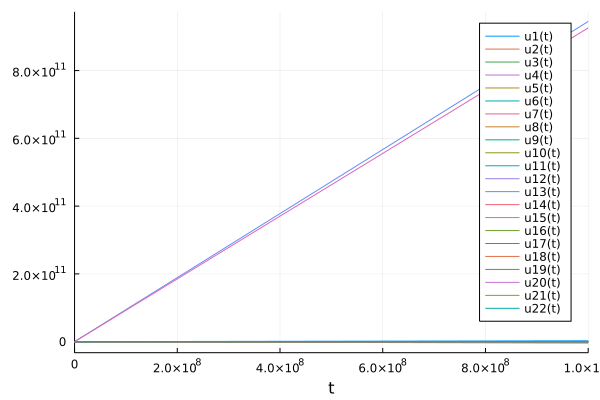

In [15]:
plot(sol)

In [16]:
speciesn = [:r, :et, :em, :q, :si, :a, :p, :mr, :mt, :mm, :mq, :mp, :cr, :ct, :cm, :cq, :cp]

probn = ODEProblem(odemodel!,init,tspan,params)
soln = solve(probn, alg=Rosenbrock23())
solDF = DataFrame([[j[i] for j in soln.u] for i=1:length(soln.u[1])], speciesn)
# a = solDF[!, :zmp]


,r,et,em,q,si,a,p
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.0,0.0,0.0,0.0,0.0,1000.0,0.0
2,10.0,6.65724e-17,6.65724e-17,1.52622e-14,2.0499e-20,1000.0,6.65724e-17
3,10.0,8.43126e-14,8.43126e-14,1.93293e-11,2.66202e-16,1000.0,8.43126e-14
4,9.99985,8.62177e-11,8.62177e-11,1.9766e-8,2.72968e-12,1000.0,8.62177e-11
5,9.99939,6.24513e-10,6.24513e-10,1.43174e-7,3.2314e-11,1000.0,6.24513e-10
6,9.99747,5.25404e-9,5.25404e-9,1.20453e-6,5.38029e-10,999.999,5.25404e-9
7,9.9935,2.13499e-8,2.13499e-8,4.89462e-6,3.37587e-9,999.998,2.13499e-8
8,9.98339,8.69762e-8,8.69762e-8,1.99399e-5,2.1792e-8,999.99,8.69762e-8
9,9.96732,2.39191e-7,2.39191e-7,5.48362e-5,8.29627e-8,999.972,2.39191e-7


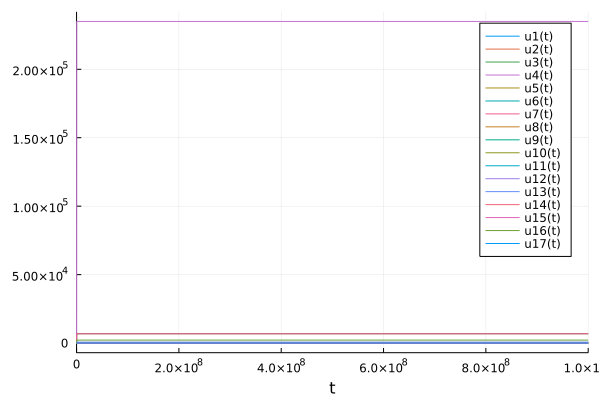

In [17]:
plot(soln)